# 一般化線形混合モデル（GLMM）
+ 果実の収穫量について分析
+ Poisson分布で良さそうだが、個体差が大きく、平均＜＜＜分散（過分散）の状況
+ 個体差を取りいれたモデルにする必要がある

### ランダム効果
+ 収穫量の Poisson分布 $P(\theta)$ の各 $\theta$ が以下の要素で個別に生成されることを仮定
> $\theta_i　= b + r_i$<br>
> where<br>
> $b = \beta_0 + \beta_1 x$ ← 固定効果<br>
> $r_i \sim N(0, s)$ ← ランダム効果（正規分布から発生する個体差）　

In [1]:
import numpyro
import numpyro.distributions as dist

import jax
import arviz as az

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
%config InlineBackend.figure_format = 'retina'

In [2]:
# cpu がどんな感じで動いているか？
jax.devices()

[CpuDevice(id=0)]

In [3]:
df = pd.DataFrame({
    'num_fruits': [445, 378, 383, 406, 458, 433, 568, 521, 446, 437, 327, 508, 342, 385, 363, 495, 347, 419, 380, 582]
})

データ：「果実量」

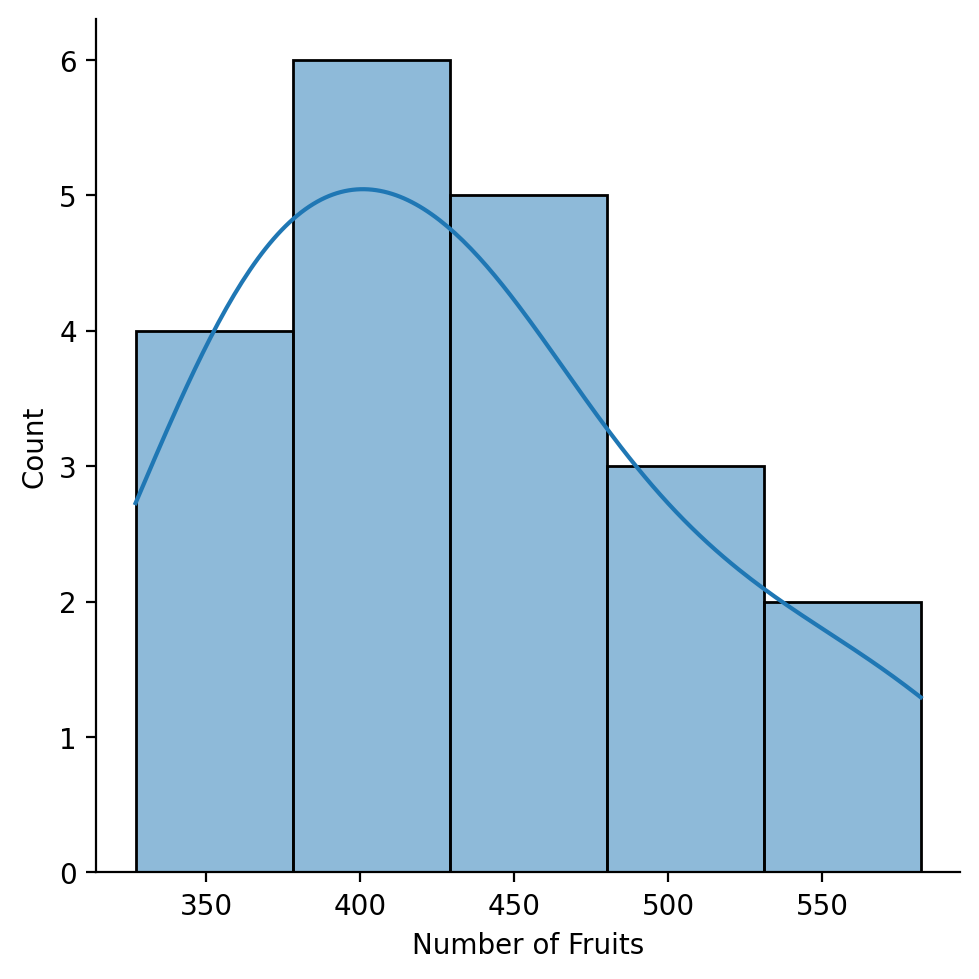

In [4]:
sns.displot(data = df, x = 'num_fruits', kde = True, binwidth = 50)
plt.xlabel("Number of Fruits");

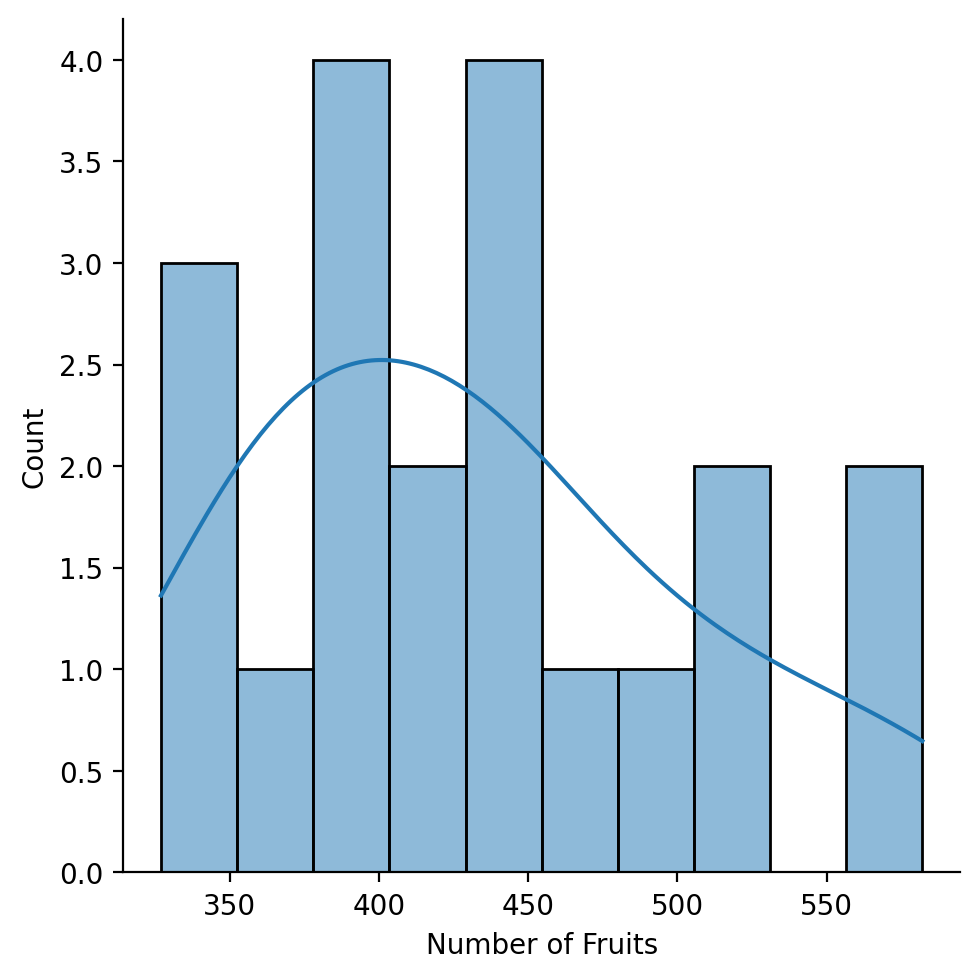

In [5]:
sns.displot(data = df, x = 'num_fruits', kde = True, binwidth = 25)
plt.xlabel("Number of Fruits");

In [6]:
print('平均：{:2f}'.format(df['num_fruits'].mean()))
print('分散：{:2f}'.format(df['num_fruits'].var()))

平均：431.150000
分散：5363.186842


Poisson分布における「過分散」という状態になっていそう

In [7]:
y = df['num_fruits'].values
num_trees = len(y)

In [8]:
def model(y = None, num_data = 0):

    # 線形予測子
    b = numpyro.sample('b', dist.Normal(0, 10))

    s = numpyro.sample('s', dist.HalfCauchy(5))
    r = numpyro.sample('r', dist.Normal(0, s), sample_shape = (num_trees,))

    theta = b + r

    # リンク関数
    mu = jax.numpy.exp(theta)

    # 観測データ（Y）に基づく尤度の定義
    with numpyro.plate('data', num_data):
        numpyro.sample('obs', dist.Poisson(mu), obs = y)

In [9]:
nuts = numpyro.infer.NUTS(model)
mcmc = numpyro.infer.MCMC(nuts, num_warmup = 500, num_samples = 3000, num_chains = 4)

mcmc.run(jax.random.PRNGKey(42), y = y, num_data = num_trees)

mcmc_samples = mcmc.get_samples()

idata = az.from_numpyro(mcmc)

/var/folders/03/smvv0jp54c5cnt0xtqz_1gkc0000gn/T/ipykernel_19624/1632489944.py:2: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = numpyro.infer.MCMC(nuts, num_warmup = 500, num_samples = 3000, num_chains = 4)
sample: 100%|█| 3500/3500 [00:01<00:00
sample: 100%|█| 3500/3500 [00:00<00:00
sample: 100%|█| 3500/3500 [00:00<00:00
sample: 100%|█| 3500/3500 [00:00<00:00


In [10]:
idata

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

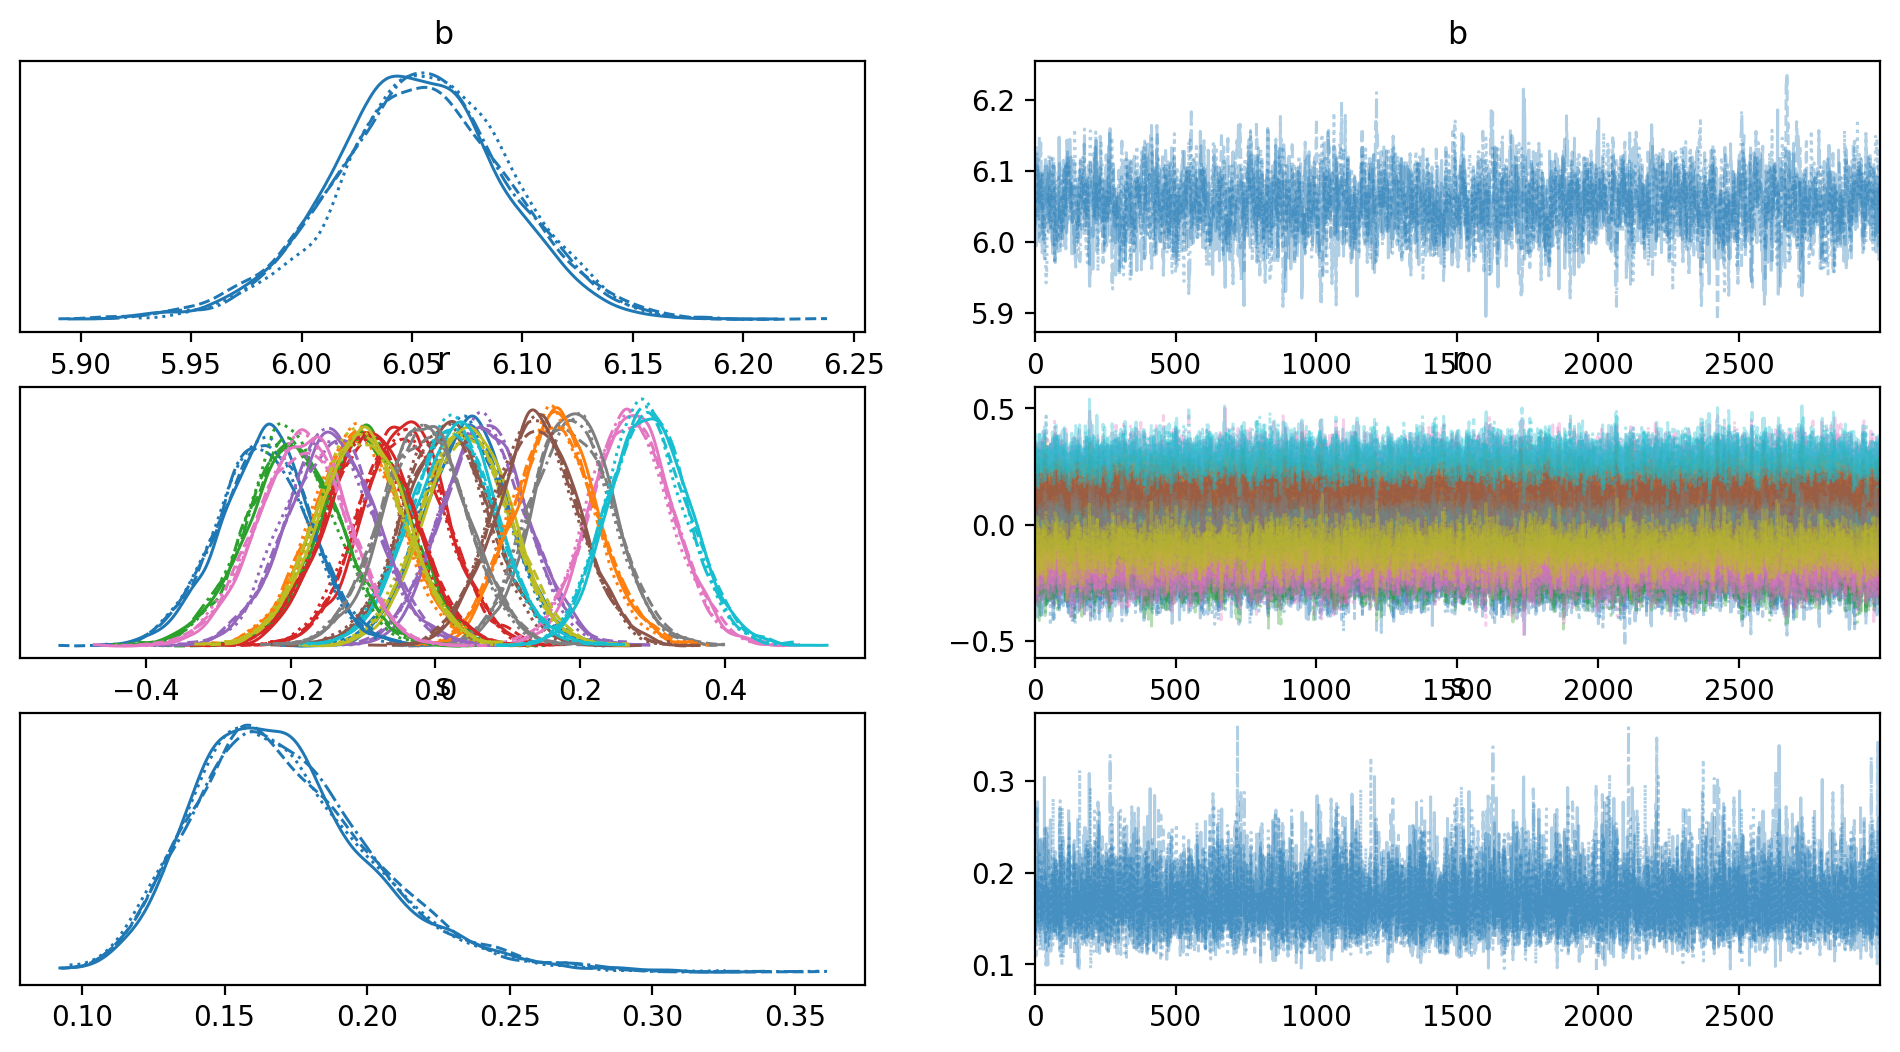

In [11]:
az.plot_trace(idata);

In [12]:
az.summary(idata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
b,6.054,0.040,5.976,6.128,0.001,0.001,1919.0,3211.0,1.0
r[0],0.040,0.059,-0.071,0.148,0.001,0.001,3879.0,5681.0,1.0
r[1],-0.109,0.061,-0.224,0.006,0.001,0.001,4027.0,5826.0,1.0
r[2],-0.097,0.061,-0.212,0.016,0.001,0.001,3864.0,5708.0,1.0
r[3],-0.045,0.060,-0.159,0.067,0.001,0.001,4054.0,6543.0,1.0
r[4],0.067,0.059,-0.038,0.183,0.001,0.001,3949.0,6492.0,1.0
r[5],0.015,0.060,-0.095,0.131,0.001,0.001,3946.0,6361.0,1.0
r[6],0.270,0.057,0.166,0.379,0.001,0.001,3581.0,5675.0,1.0
r[7],0.188,0.057,0.083,0.295,0.001,0.001,3549.0,5184.0,1.0
r[8],0.042,0.060,-0.072,0.150,0.001,0.001,3860.0,5398.0,1.0


### ■ 疑問
+ r_hat を見る理由は？

### ChatGPT
ベイズ統計モデリングの文脈での $\hat{R}$（しばしば "R hat" と呼ばれます）は、マルコフ連鎖モンテカルロ（MCMC）手法で生成されたサンプルの収束診断に用いられる指標です。<br>
特に、ハミルトニアン・モンテカルロ（HMC）やその変種、例えばNumPyroライブラリで実装されているNo-U-Turn Sampler（NUTS）などで利用されます。

＃### R hat ( R^R^ ) の意味
+ 目的:
    + $\hat{R}$ は、複数のMCMCチェーンが同じ基礎的な分布からサンプリングしているかどうかを評価するために使用されます。
    + つまり、MCMCサンプルが収束しているかどうかを判断するための指標です。
+ 理想的な値:
    + 一般的に、$\hat{R}$ の値が 1 に近い（通常、1.01 以下など）ことは、チェーンが収束していると考えられます。
    + これは、異なるチェーンが統計的に類似した特性を持っていることを意味します。

### 計算方法
+ 分散の比較:
    + $\hat{R}$ は、MCMCサンプルの内部（各チェーン内）と外部（チェーン間）の分散を比較することによって計算されます。
    + 内部分散が小さく、外部分散が大きい場合、$\hat{R}$ は大きな値を取ります。
+ 式:
    + 計算には、チェーン内分散とチェーン間分散の推定値、および効果的なサンプルサイズ（ESS）が関与します。
    + この式は少し複雑で、具体的な数式は専門的な統計の文献で詳しく説明されています。

### 解釈
+ $\hat{R}$≈1:
    + すべてのチェーンが同じ分布に収束している可能性が高い。パラメータの推定は安定していると考えられます。
+ $\hat{R}$>1:
    + チェーン間に顕著な違いがあることを示唆しています。これは、いくつかのチェーンがまだ収束していないか、異なる局所的な最適解に収束している可能性があります。
+ 対応策:
  + $\hat{R}$ が 1 より大きい場合、長いバーンイン期間、より多くのサンプル、または異なる初期値の設定を試すことが推奨されます。

最終的に、$\hat{R}$ はMCMCサンプリングの品質を評価するための重要なツールですが、他の診断と併用することが一般的です。<br>
例えば、トレースプロットの視覚的な検査や、効果的なサンプルサイズ（ESS）の計算などがあります。<br>
これらの結果を総合的に評価することで、MCMCサンプリングの信頼性をよりよく判断することができます。

In [24]:
%%time
# 事後予測チェックは mcmc_samples を引数に入れて predictive を生成する

predictive = numpyro.infer.Predictive(model, mcmc_samples)
# ppc_samples = predictive(jax.random.PRNGKey(42), y = y, num_data = num_trees) ←　これが間違い
ppc_samples = predictive(jax.random.PRNGKey(42), num_data = num_trees)

idata_ppc = az.from_numpyro(mcmc, posterior_predictive = ppc_samples)

CPU times: user 464 ms, sys: 12.2 ms, total: 476 ms
Wall time: 467 ms


In [25]:
ppc_samples['obs'].shape

(12000, 20)

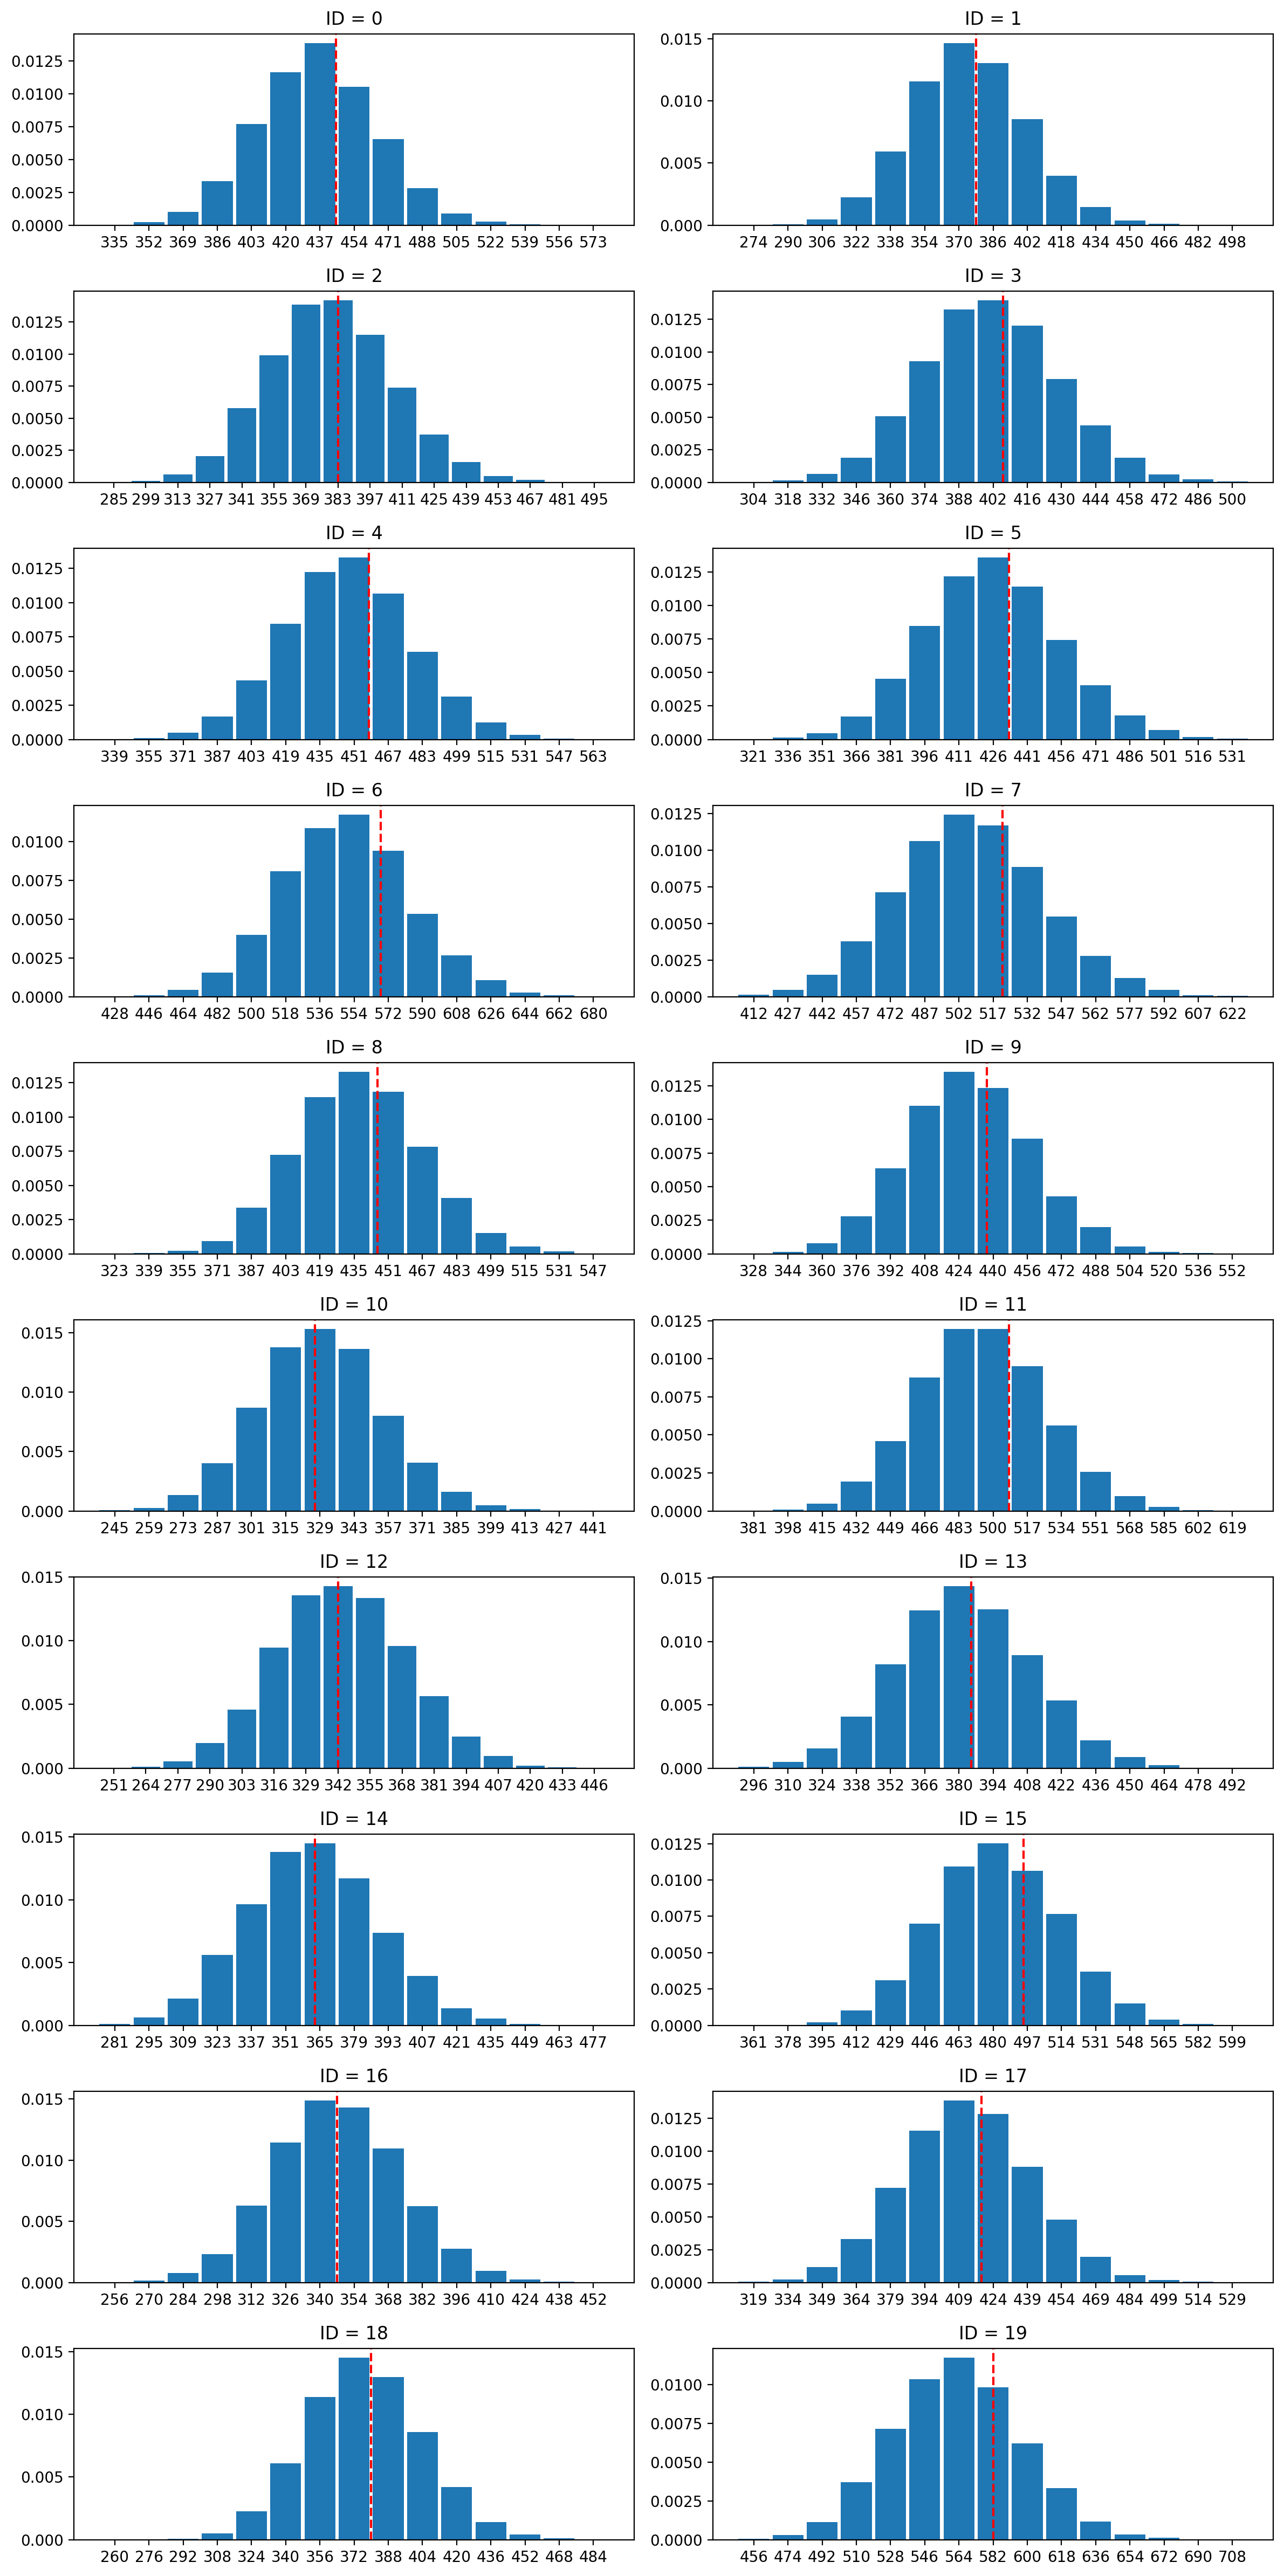

In [26]:
fig = plt.figure(figsize = (12, 24))

for k in range(20):
    
    ax = fig.add_subplot(10, 2, k+1)

    az.plot_dist(ppc_samples['obs'][:, k])
    ax.axvline(y[k], color = 'r', linestyle = 'dashed')
    ax.set_title('ID = {}'.format(k))

plt.tight_layout()

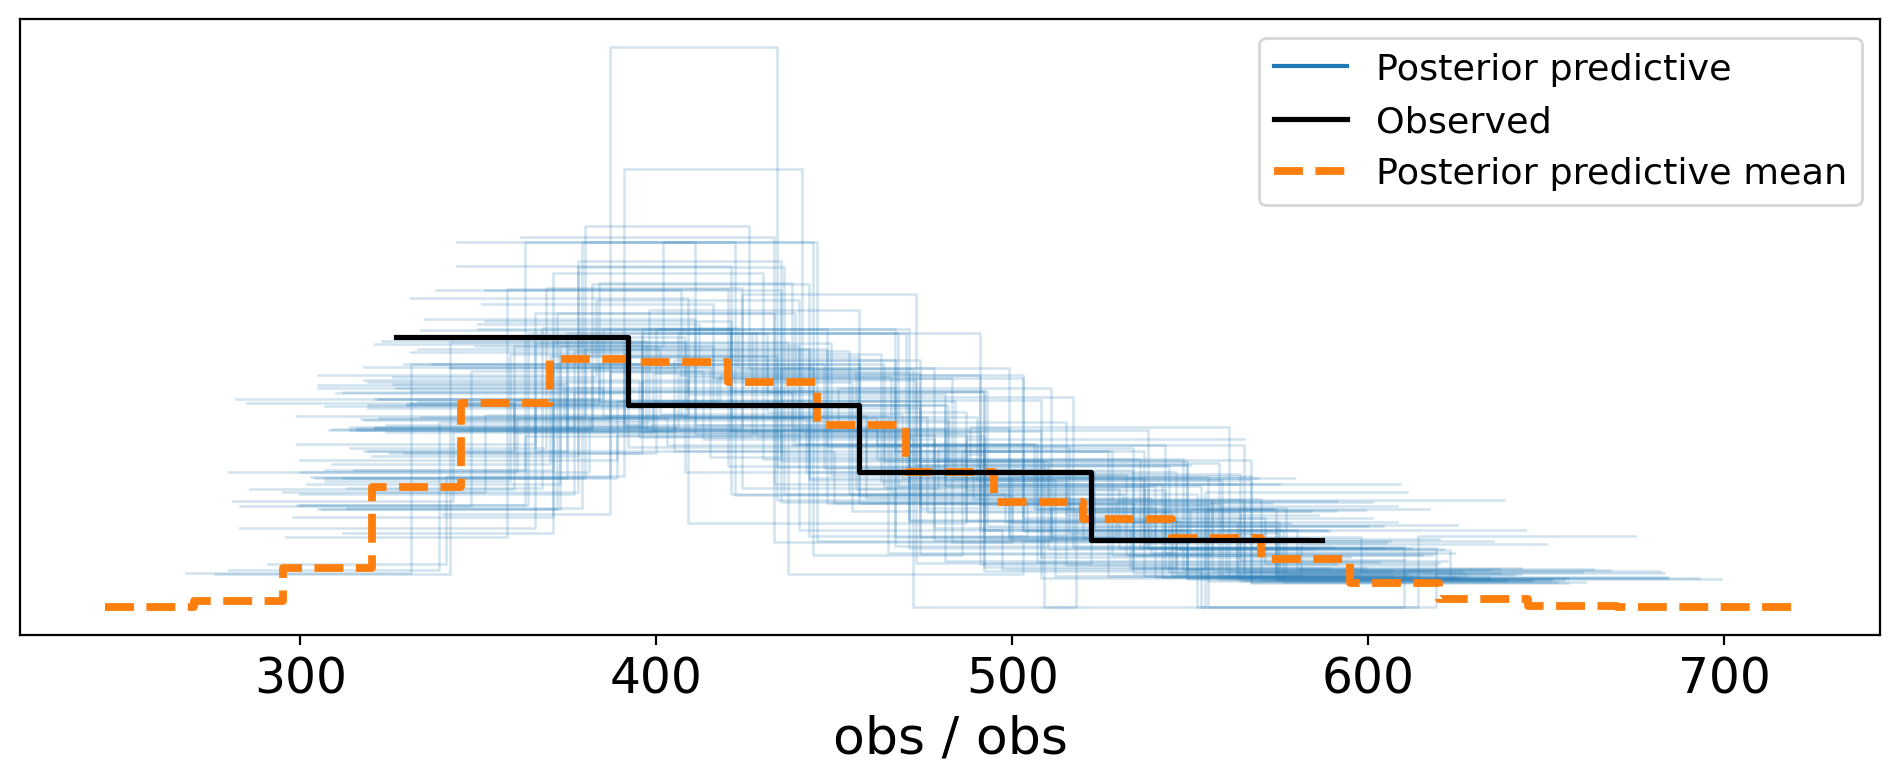

In [30]:
az.plot_ppc(idata_ppc, kind = 'kde', num_pp_samples = 100, figsize = (12,4));

#### ■ 疑問
+ 300〜400の間で実際のデータは右下がりなのに、事後分布（青・オレンジ）では山を登っている。
+ これはいいの？修正する方法ないの？

### ランダム効果の確認
+ 木によってだいぶ実のなりやすさに差がある

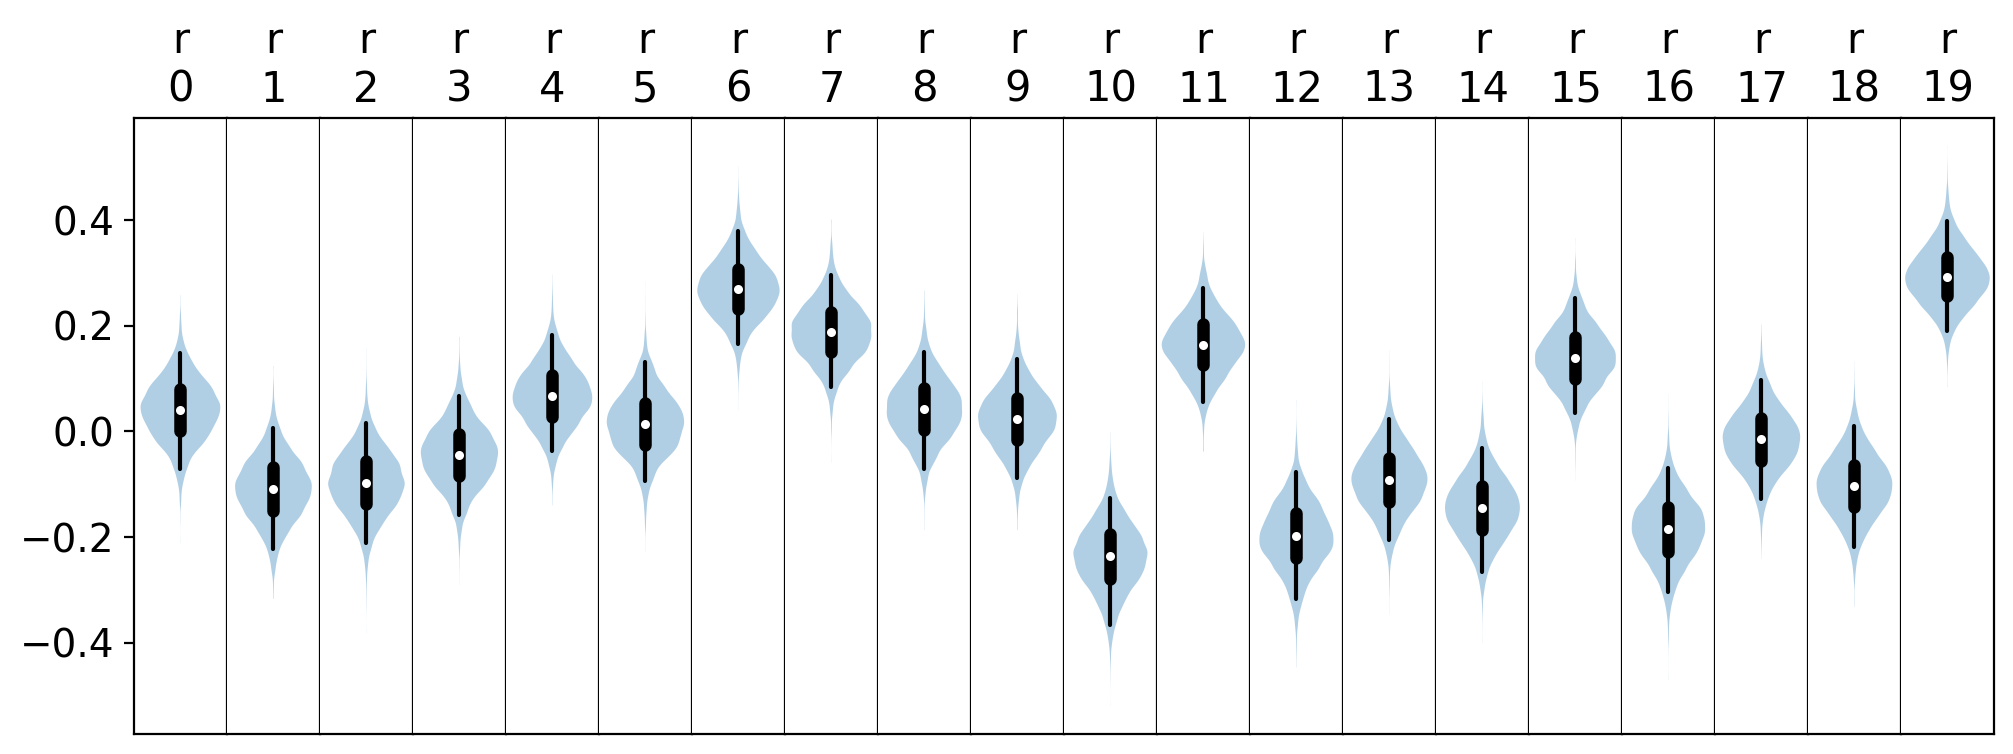

In [35]:
az.plot_violin(idata.posterior['r'], grid = (1, num_trees), figsize = (12,4));

### 後から特徴量取れるよって分かった場合
+ ランダム効果と「成長度」をプロットするとどうも正の相関がありそうだ

In [39]:
df = pd.DataFrame({
    'num_fruits': [445, 378, 383, 406, 458, 433, 568, 521, 446, 437, 327, 508, 342, 385, 363, 495, 347, 419, 380, 582],
    'span': [4.0, 4.0, 4.5, 3.8, 3.7, 4.1, 4.2, 4.5, 3.9, 4.0, 3.2, 3.9, 3.0, 4.1, 3.7, 4.9, 4.3, 4.0, 3.1, 4.8]
    
})

In [16]:
# ここから教科書見ずに実装

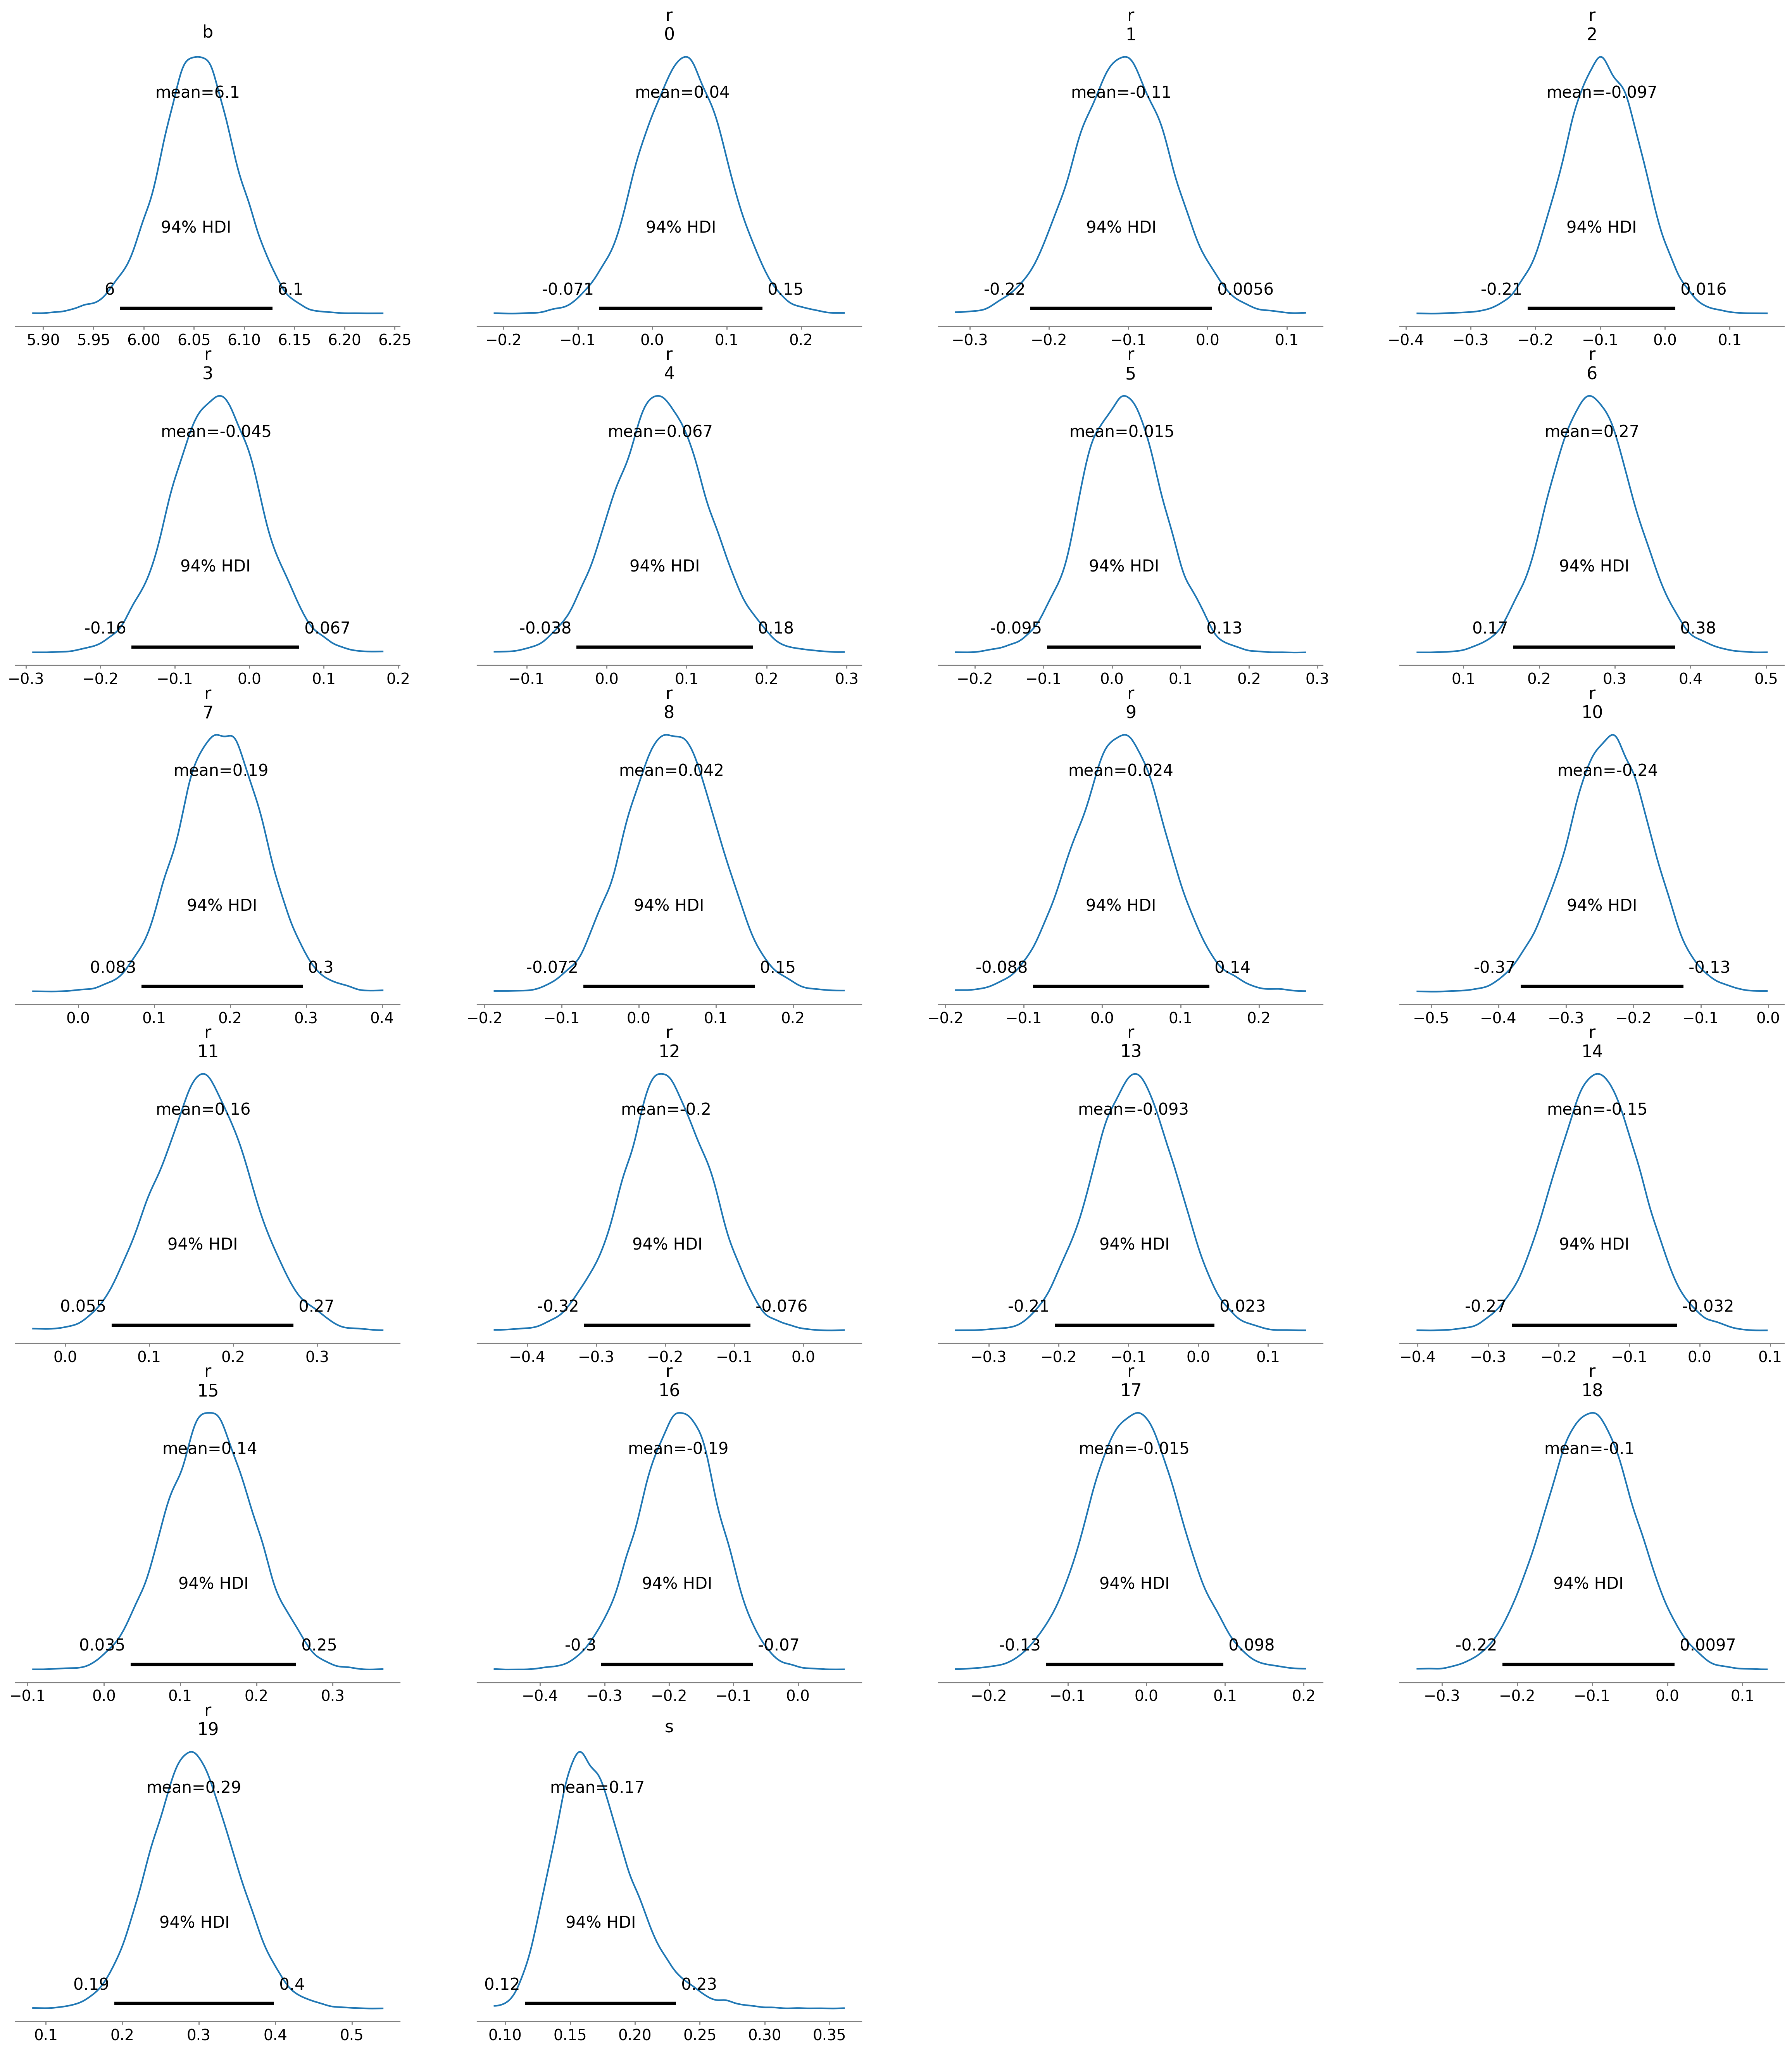

In [17]:
az.plot_posterior(idata);

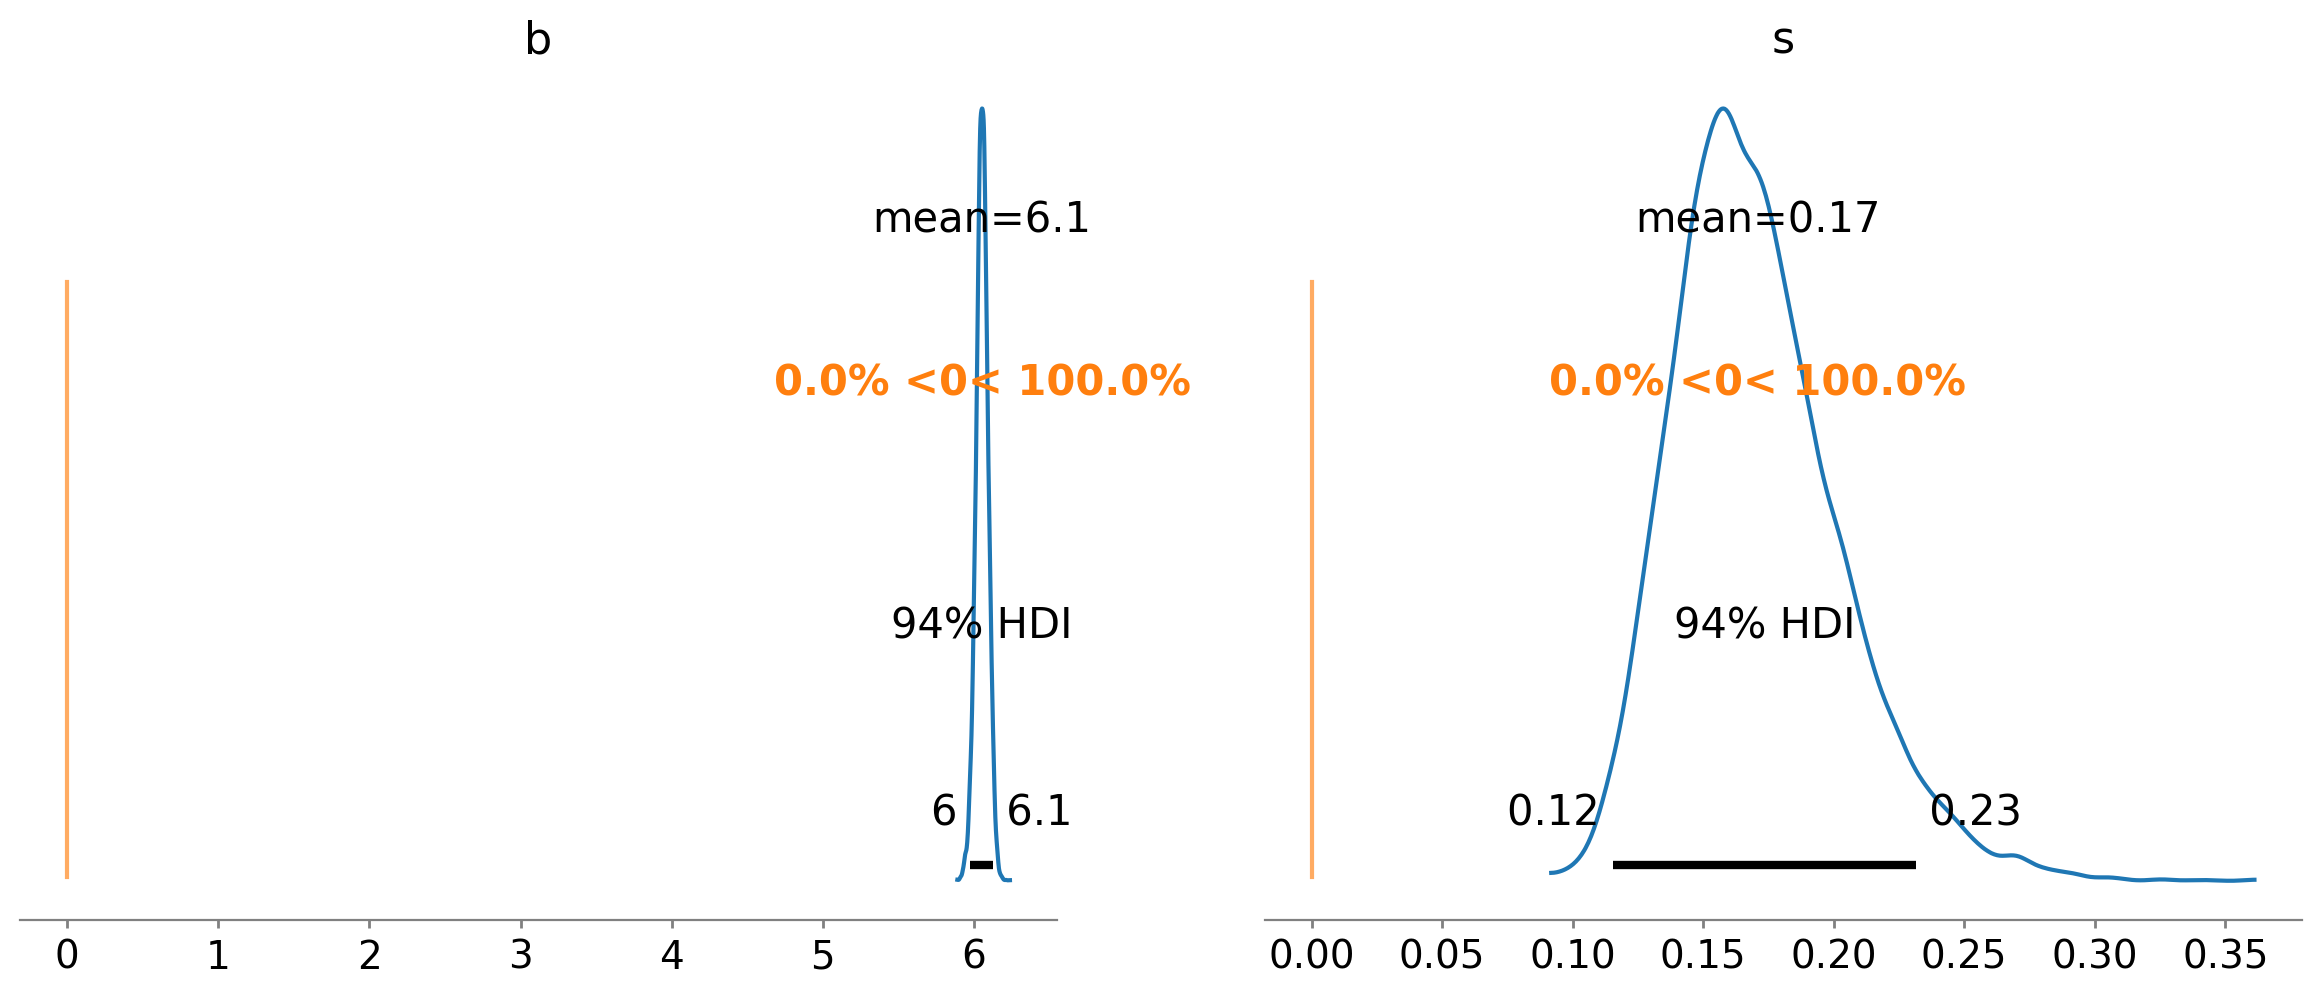

In [18]:
az.plot_posterior(idata, var_names = ['b', 's'], ref_val = 0);

## 事後予測チェック（PPC：Post Predictive Check）
model がちゃんと真のパラメーターを説明できているかどうか

In [19]:
%%time
# 事後予測チェックは mcmc_samples を引数に入れて predictive を生成する

predictive = numpyro.infer.Predictive(model, mcmc_samples)
ppc_samples = predictive(jax.random.PRNGKey(42), y = y, num_data = num_trees)

idata_ppc = az.from_numpyro(mcmc, posterior_predictive = ppc_samples)

CPU times: user 169 ms, sys: 5.11 ms, total: 174 ms
Wall time: 60.1 ms


In [20]:
ppc_samples['obs'].shape

(12000, 20)

In [21]:
idata_ppc

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> observed_data

これじゃ出せない

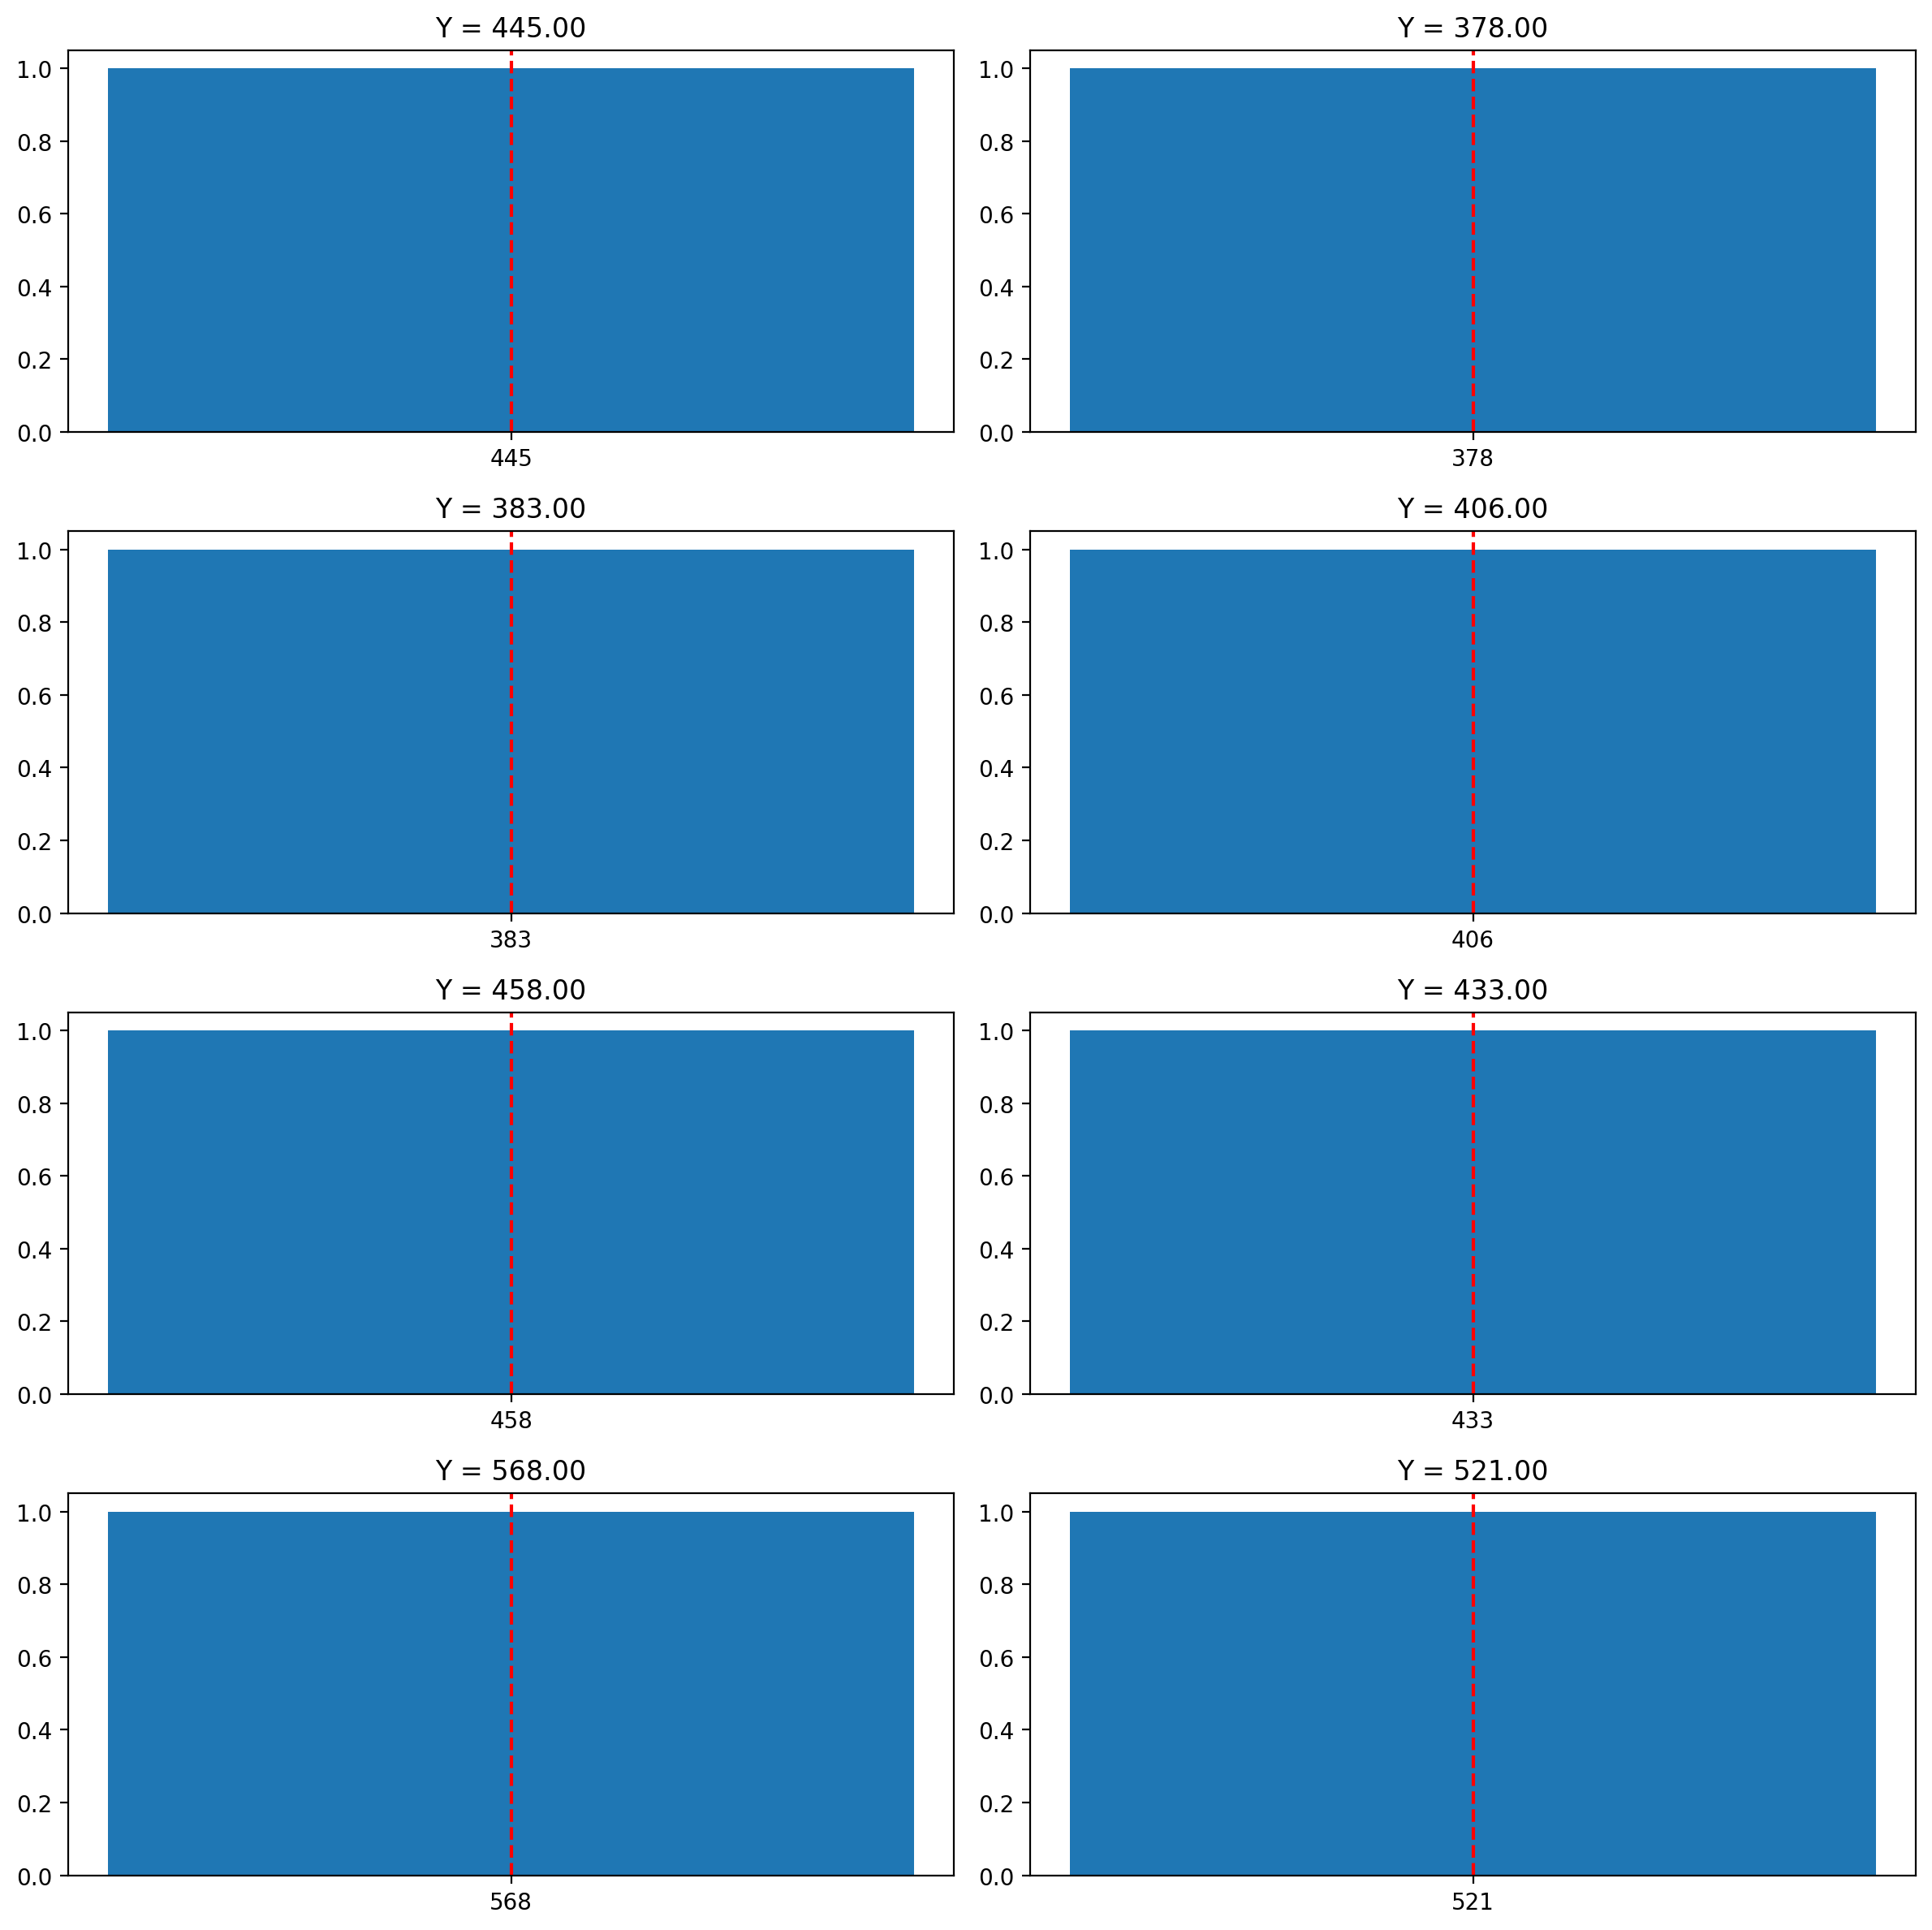

In [22]:
fig = plt.figure(figsize = (12, 12))

for k in range(8):
        
    ax = fig.add_subplot(4, 2, k+1)

    az.plot_dist(ppc_samples['obs'][:, k]) # ppc_samples の　obs なので mcmc で作ったサンプル(実際の観測データ8個に対して)
    ax.axvline(y[k], color = 'r', linestyle = 'dashed') # deaths　は実際の観測データ（8個）
    ax.set_title('Y = {:.2f}'.format(y[k]))

plt.tight_layout()

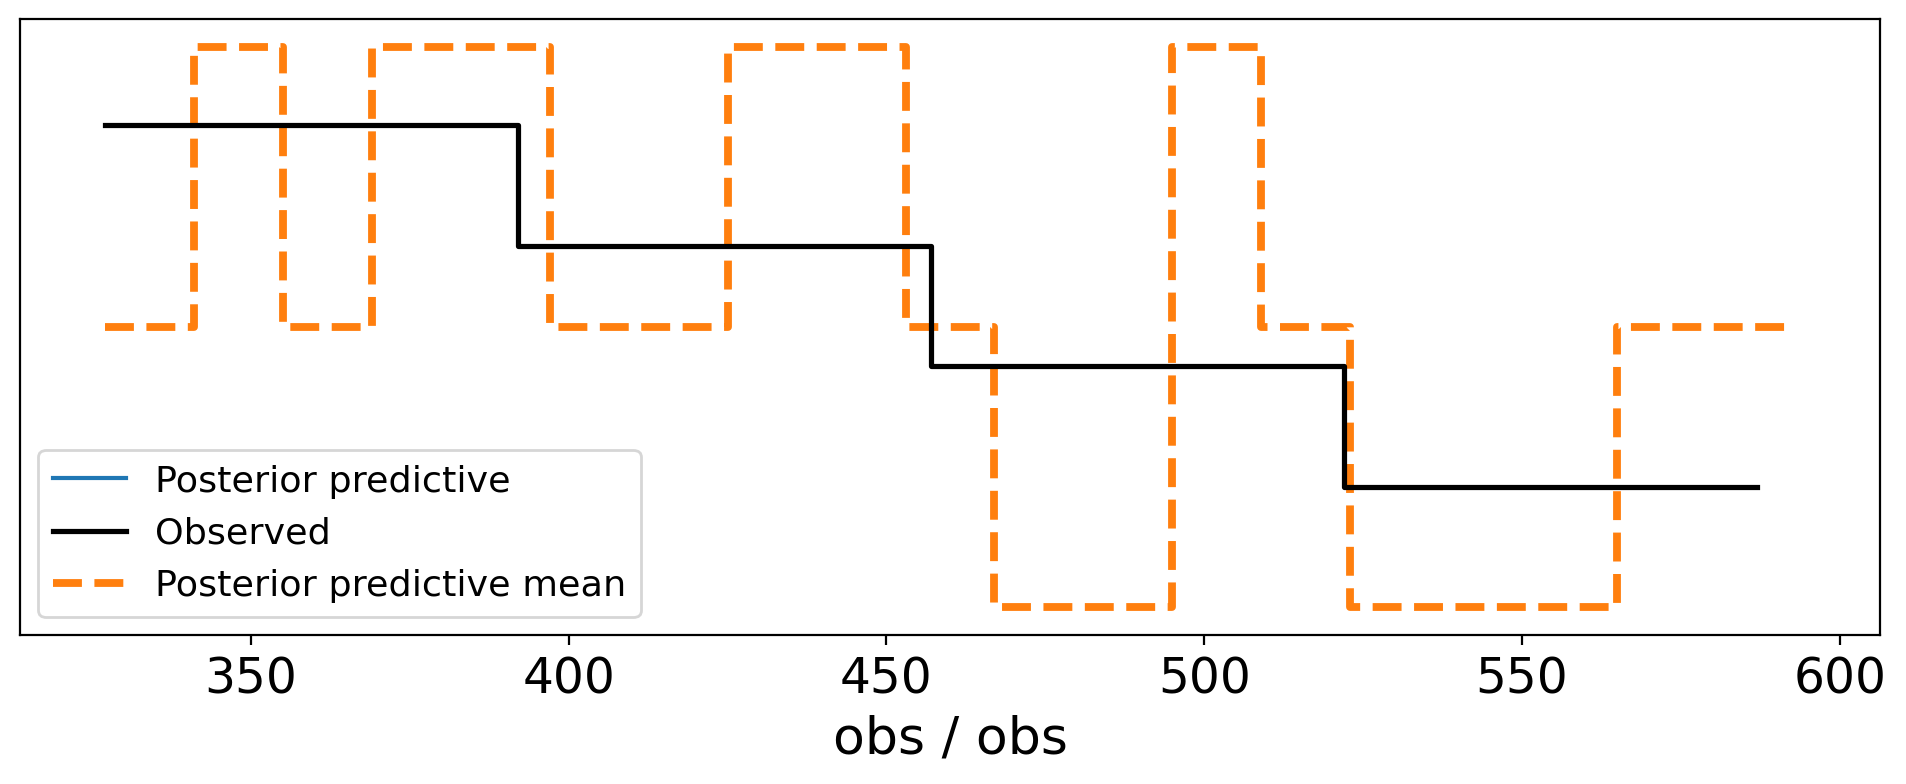

In [23]:
az.plot_ppc(idata_ppc, kind = 'kde', num_pp_samples = 10, figsize = (12,4));